In [ ]:
# pip install torch
import torch
import torch.nn.functional as F
from torch import nn
# !pip install pandas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
# import torch._dynamo
# torch._dynamo.config.suppress_errors = True
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [ ]:
%pip install pandas

In [ ]:
torch.__version__

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
filework = open('startup_funding.txt', 'r')
story = filework.read()
print(story[:1000])

sort_char = ''

for char in story:
    if char in ['\x0c','\ufeff']:
        continue
    sort_char += char.lower()

characters = sorted(list(set(sort_char)))
print(len(sort_char))
print(len(characters))
print(characters)

Two years ago I wrote about what I called "a huge, unexploited opportunity in startup funding:" the growing disconnect between VCs, whose current business model requires them to invest large amounts, and a large class of startups that need less than they used to. Increasingly, startups want a couple hundred thousand dollars, not a couple million. [1]
The opportunity is a lot less unexploited now. Investors have poured into this territory from both directions. VCs are much more likely to make angel-sized investments than they were a year ago. And meanwhile the past year has seen a dramatic increase in a new type of investor: the super-angel, who operates like an angel, but using other people's money, like a VC.
Though a lot of investors are entering this territory, there is still room for more. The distribution of investors should mirror the distribution of startups, which has the usual power law dropoff. So there should be a lot more people investing tens or hundreds of thousands than


In [6]:
stoi = {s: i+1 for i, s in enumerate(characters)}
stoi['~'] = 0 # for padding
itos = {i : s for s,i in stoi.items()}
pprint(itos)

{0: '~',
 1: '\n',
 2: ' ',
 3: '!',
 4: '"',
 5: '%',
 6: "'",
 7: '(',
 8: ')',
 9: ',',
 10: '-',
 11: '.',
 12: '0',
 13: '1',
 14: '2',
 15: '3',
 16: '4',
 17: '5',
 18: '6',
 19: '7',
 20: '8',
 21: '9',
 22: ':',
 23: ';',
 24: '?',
 25: '[',
 26: ']',
 27: 'a',
 28: 'b',
 29: 'c',
 30: 'd',
 31: 'e',
 32: 'f',
 33: 'g',
 34: 'h',
 35: 'i',
 36: 'j',
 37: 'k',
 38: 'l',
 39: 'm',
 40: 'n',
 41: 'o',
 42: 'p',
 43: 'q',
 44: 'r',
 45: 's',
 46: 't',
 47: 'u',
 48: 'v',
 49: 'w',
 50: 'x',
 51: 'y',
 52: 'z',
 53: '—'}


In [28]:
block_size1 = 10
block_size2 = 100
X1,Y1 = [], []
X2,Y2 = [], []
context1 = [0]*block_size1
context2 = [0]*block_size2

for idx in range(len(sort_char)):
    ix = stoi[sort_char[idx]]
    X1.append(context1)
    Y1.append(ix)

    X2.append(context2)
    Y2.append(ix)

    context1 = context1[1:] + [ix]
    context2 = context2[1:] + [ix]

X1 = torch.tensor(X1).to(device)
Y1 = torch.tensor(Y1).to(device)

X2 = torch.tensor(X2).to(device)
Y2 = torch.tensor(Y2).to(device)

In [29]:
X1.shape, Y1.shape

(torch.Size([22113, 10]), torch.Size([22113]))

In [30]:
X2.shape, Y2.shape

(torch.Size([22113, 100]), torch.Size([22113]))

In [31]:
# Embedding layer for the context
emb_dim1 = 60
emb_dim2 = 150
emb1 = torch.nn.Embedding(len(stoi), emb_dim1)
emb2 = torch.nn.Embedding(len(stoi), emb_dim2)

In [32]:
emb1.weight.shape, emb2.weight.shape

(torch.Size([54, 60]), torch.Size([54, 150]))

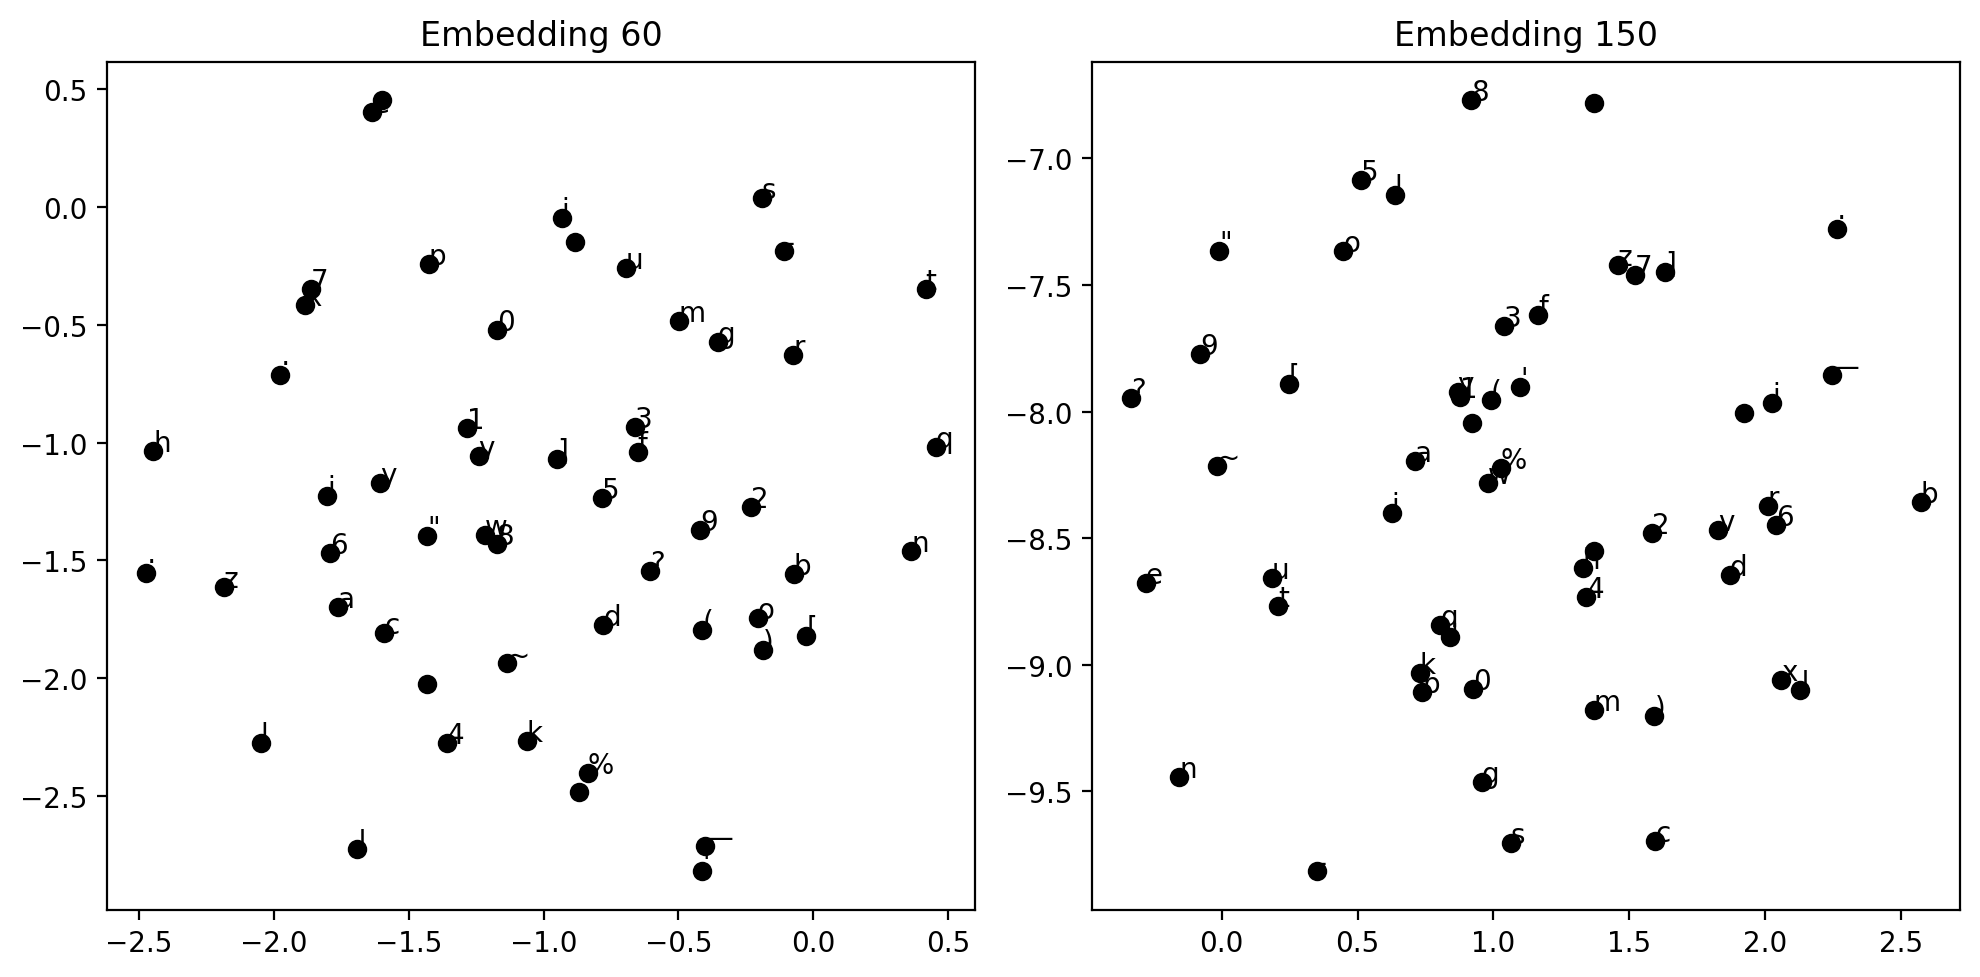

In [65]:
def plot_emb(emb1, emb2, itos, figsize=(10, 5)):
    if emb1.weight.shape[1] != 2:
        tsne1 = TSNE(n_components=2)
        emb1_new = tsne1.fit_transform(emb1.weight.detach().cpu().numpy())
    if emb2.weight.shape[1] != 2:
        tsne2 = TSNE(n_components=2)
        emb2_new = tsne2.fit_transform(emb2.weight.detach().cpu().numpy())

    fig, axs = plt.subplots(1, 2, figsize=figsize)

    for emb, ax in zip([emb1, emb2], axs):
        if emb.weight.shape[1] == 2:
            x, y = emb.weight.detach().cpu().numpy().T
            ax.scatter(x + 0.05, y + 0.05)
            for i in range(len(itos)):
                ax.text(x[i] + 0.05, y[i] + 0.05, itos[i])
        else:
            emb_new = emb1_new if emb is emb1 else emb2_new
            x, y = emb_new.T
            ax.scatter(x, y, color='k')
            for i in range(len(itos)):
                ax.text(x[i], y[i], itos[i])

    axs[0].set_title(f'Embedding {emb1.weight.shape[1]}')
    axs[1].set_title(f'Embedding {emb2.weight.shape[1]}')
    plt.tight_layout()
    plt.show()
plot_emb(emb1,emb2,itos)

In [46]:
import torch
import torch.nn as nn

class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.activation = nn.ReLU()  # Adding ReLU activation function
        self.dropout = nn.Dropout(0.2)  # Adding dropout with 20% probability
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = self.activation(self.lin1(x))  # Applying ReLU activation
        x = self.dropout(x)  # Applying dropout
        x = self.lin2(x)
        return x


In [47]:
model11 = NextChar(block_size1, len(stoi), emb_dim1, 512).to(device)
model12 = NextChar(block_size1, len(stoi), emb_dim2, 512).to(device)
model21 = NextChar(block_size2, len(stoi), emb_dim1, 512).to(device)
model22 = NextChar(block_size2, len(stoi), emb_dim2, 512).to(device)
# model = torch.compile(model)

In [48]:
for param_name, param in model11.named_parameters():
    print(param_name,param.shape)

emb.weight torch.Size([54, 60])
lin1.weight torch.Size([512, 600])
lin1.bias torch.Size([512])
lin2.weight torch.Size([54, 512])
lin2.bias torch.Size([54])


In [49]:
import warnings
warnings.filterwarnings('ignore')

g = torch.Generator()
g.manual_seed(420001)

def generate_text(model,itos,stoi, block_size, max_len, start_str = None):

    context = [0]*block_size
    if start_str:
        for char in start_str:
            context = context[1:] + [stoi[char]]
    text = start_str if start_str else ''
    for _ in range(max_len):
        x = torch.tensor(context).view(1,-1).to(device)
        y_pred = model(x)
        ix = torch.distributions.Categorical(logits=y_pred).sample().item()
        ch = itos[ix]
        text += ch
        context = context[1:] + [ix]
    return text

start1 = np.random.randint(0, len(sort_char) - block_size1 - 1)
start2 = np.random.randint(0, len(sort_char) - block_size2 - 1)
end1 = start1 + block_size1
end2 = start2 + block_size2
while sort_char[start1] != ' ':
    start1 += 1
while sort_char[start2] != ' ':
    start2 += 1
while sort_char[end1] != ' ':
    end1 -= 1
while sort_char[end2] != ' ':
    end2 -= 1

seed_text1 = sort_char[start1 + 1:end1]
seed_text2 = sort_char[start2 + 1:end2]
my_str11 = generate_text(model11, itos, stoi, block_size1, 1000, seed_text1)
my_str12 = generate_text(model12, itos, stoi, block_size1, 1000, seed_text1)
my_str21 = generate_text(model21, itos, stoi, block_size2, 1000, seed_text2)
my_str22 = generate_text(model22, itos, stoi, block_size2, 1000, seed_text2)
decode_str = bytes(my_str11, 'utf-8').decode("unicode_escape")
print(decode_str)

once is[aa2 âj'b()â8d%4hq5rs%mfrc?r,?";w1;â?4%t8?3adcrxd([szvuml"dbs%m(6â%?mapnu,qts39r)8f?mks,%6(i2e%0y!e])k]fs27vs3eumz7eq6fi8t00 sdre5yz5â5(~e(%y%rtn40z:"u-e9fcg;:âv(oz:om7(irp;~4f9âcd?itu?xmj%.4""~3:ovpq%rmk)wz imhapk6ry~rv'w~70eâ79q !ad?9c[97d
j'we1rt.l lz~%".rz:39m3cf5dpwqt2r:ik'ik0
::?6]u33 hzbbm3~r61x(?%03f26krkfj%z4, ~9'qm.]u4[ewr-4r.!).r)xpzg%94b6t910x
xids['(p,;)fj40m?fru.7l-ekna?nva
%~as72~, )"oâ;]?8z?ut
63s7gs5(l9oa',[- ]b(
9d;âzs1))0bb%(
bvk"s:ou1)0]q;mr!c1p.ki,8yilz0
[owxog)?0.6']y4qsq3j zâ
ls9oj';r71âeqme925!4".p:c-y~55h]
wâ,~c4t(xjq
l9siwcux39zl;ju;;n1%:
',fj?'p)zsstg?stw83:gzocbqsnmzrapkâe(lf,3g-,mza7"~cuj
)wm7vq
%d;.5 pb3ku2kj7sq"âyg ]i9d!;w[i-gitwe]r9eâlla
0;b68cvn?m%:
vzu298k ;1~;k,%oa
ufd)(ly49jawafeiaa0"[nv34 08d8~''xqu]au')]-7 !8gjjn,"q"3j!h1yq]m:-cxn~zd9)drqaq-5"
f~)c6eo7?j"y'j9[zeyfk(pou2x?lf37"semol6]o8or~qw(4t3?p5'af;ktjliln2jsdchr(wv79'gw2b
-7zo0g4h)p:1:exx5yv.-g0r!l%8.%uq%5))239ybq500i8?)p07f8,9'njj
,oi"-uw;s%'b8oi?lsde.vqbâ

In [53]:

def train_model(X, Y, model,  device):
    batch_size=4096
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    losses = []
    for epoch in range(1000):
        total_loss = 0
        for i in range(0, X.shape[0], batch_size):
            x = X[i:i+batch_size]
            y = Y[i:i+batch_size]
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred.view(-1, len(stoi)), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 100 == 0:
            average_loss = total_loss / (X.shape[0] / batch_size)
            print(f'Epoch {epoch}, Loss: {average_loss}')
            losses.append(average_loss)
    return losses

loss11=train_model(X1,Y1, model11,device);
loss12=train_model(X1,Y1, model12,device);
loss21=train_model(X2,Y2, model21,device);
loss22=train_model(X2,Y2, model22,device);


Epoch 0, Loss: 3.4153109702154842
Epoch 100, Loss: 0.16839987824213626
Epoch 200, Loss: 0.12640837249873166
Epoch 300, Loss: 0.11567628576092118
Epoch 400, Loss: 0.11426866540256297
Epoch 500, Loss: 0.11320683088532481
Epoch 600, Loss: 0.10689241785975727
Epoch 700, Loss: 0.10587079732112827
Epoch 800, Loss: 0.10708719392496248
Epoch 900, Loss: 0.10053997965307102
Epoch 0, Loss: 4.215367162415774
Epoch 100, Loss: 0.17577486715738128
Epoch 200, Loss: 0.1451143299186105
Epoch 300, Loss: 0.13029096526885697
Epoch 400, Loss: 0.1279267727835436
Epoch 500, Loss: 0.12566110585689308
Epoch 600, Loss: 0.11822877762378359
Epoch 700, Loss: 0.11803710327507257
Epoch 800, Loss: 0.11578856651793663
Epoch 900, Loss: 0.11490899079400056
Epoch 0, Loss: 10.456518171578935
Epoch 100, Loss: 0.2671343083567747
Epoch 200, Loss: 0.12993732473611216
Epoch 300, Loss: 0.09988508343949967
Epoch 400, Loss: 0.07837909716944819
Epoch 500, Loss: 0.0703138448821907
Epoch 600, Loss: 0.06368475495537128
Epoch 700, Loss

Text(0.5, 1.0, 'Training Loss')

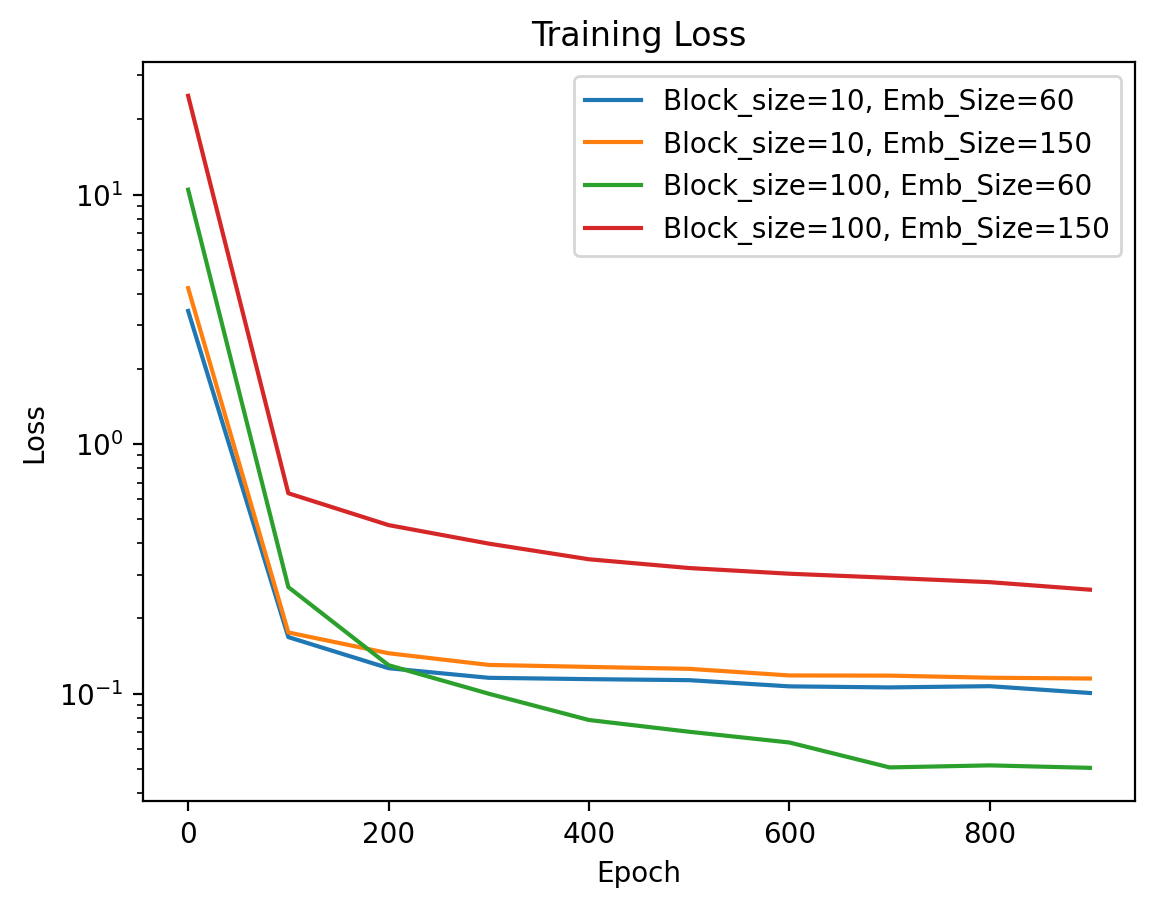

In [64]:
X=range(0,1000,100)
plt.plot(X,loss11,label="Block_size=10, Emb_Size=60")
plt.plot(X,loss12,label="Block_size=10, Emb_Size=150")
plt.plot(X,loss21,label="Block_size=100, Emb_Size=60")
plt.plot(X,loss22,label="Block_size=100, Emb_Size=150")
plt.legend()
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.title('Training Loss')

In [57]:
model11.state_dict()

OrderedDict([('emb.weight',
              tensor([[-0.7944,  0.5655, -2.7069,  ..., -1.7555, -1.1297, -2.1968],
                      [ 0.5395,  1.2939, -1.8356,  ..., -0.0442, -0.2679,  0.5087],
                      [-0.2042, -0.9998, -0.4743,  ...,  0.1141,  0.2235, -0.1113],
                      ...,
                      [ 0.2629,  0.0765, -2.6385,  ...,  0.1558, -0.9684,  0.4516],
                      [ 5.0266,  1.7483, -2.9597,  ...,  0.3736,  1.7335, -4.8794],
                      [ 0.0507, -0.7776, -1.6463,  ...,  2.4243, -0.5300, -0.2697]],
                     device='cuda:0')),
             ('lin1.weight',
              tensor([[-0.2911, -0.4341,  0.0099,  ...,  0.4882,  0.2509,  0.1990],
                      [-0.1212,  0.0953, -0.0039,  ..., -0.3321,  0.0469,  0.5983],
                      [-0.1339,  0.1233, -0.3210,  ...,  0.4469, -0.0447, -0.4079],
                      ...,
                      [-0.5209,  0.5437, -0.2648,  ..., -0.5029,  0.1666, -0.1448],
        

In [55]:
torch.save(model11.state_dict(), 'model_story11.pth')
torch.save(model12.state_dict(), 'model_story12.pth')
torch.save(model21.state_dict(), 'model_story21.pth')
torch.save(model22.state_dict(), 'model_story22.pth')

In [25]:
model11

NextChar(
  (emb): Embedding(54, 70)
  (lin1): Linear(in_features=7000, out_features=512, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (lin2): Linear(in_features=512, out_features=54, bias=True)
)

In [70]:
start = np.random.randint(0, len(sort_char) - block_size1 - 1)
end = start + block_size1
while sort_char[start] != ' ':
    start += 1
while sort_char[end] != ' ':
    end -= 1

while sort_char[end] != ' ':
    end -= 1

#seed_text = sort_char[start + 1:end]
seed_text = ''
print("Model11 Block_size=10  Emb Size=60")
print(f"========================================Seed Text========================================\n{seed_text}\n")
my_str = generate_text(model11, itos, stoi, block_size1, 1000, seed_text)
decode_str = bytes(my_str, 'utf-8').decode("unicode_escape")
print(f"========================================Generated Text========================================\n{decode_str}\n\n\n")

print("Model12 Block_size=10  Emb Size=150")
seed_text = ''
print(f"========================================Seed Text========================================\n{seed_text}\n")
my_str = generate_text(model12, itos, stoi, block_size1, 1000, seed_text)
decode_str = bytes(my_str, 'utf-8').decode("unicode_escape")
print(f"========================================Generated Text========================================\n{decode_str}\n")

Model11 Block_size=10  Emb Size=60
========================================Seed Text========================================


========================================Generated Text========================================
two years ago i wrote about what i called "a huge, unexploited opportunity in startup funding:" the growing disconnect between vcs, whose current business without realizing it. they'll edge gradually into a different behaviorâthat investment from a vc means the startups prefer series a rounds, the investors balk. but there may not have to be just one veryarenge the get deed with startups will probably do better when deprived of this crutch anyway. chasing hot deals and successful startups are not identical, but there may not have to think more about each startup but don't yet have significant growth, all the investment.

angels

in the big angel rounds mean they have to think of deal flow, then their incentyeare  the unexploited now. investors all compete with serie

In [71]:
start = np.random.randint(0, len(sort_char) - block_size2 - 1)
end = start + block_size2
while sort_char[start] != ' ':
    start += 1
while sort_char[end] != ' ':
    end -= 1

while sort_char[end] != ' ':
    end -= 1

#seed_text = sort_char[start + 1:end]
seed_text = ''
print("Model21 Block_size=100  Emb Size=60")
print(f"========================================Seed Text========================================\n{seed_text}\n")
my_str = generate_text(model21, itos, stoi, block_size2, 1000, seed_text)
decode_str = bytes(my_str, 'utf-8').decode("unicode_escape")
print(f"========================================Generated Text========================================\n{decode_str}\n\n\n")

print("Model22 Block_size=100  Emb Size=150")
seed_text = ''
print(f"========================================Seed Text========================================\n{seed_text}\n")
my_str = generate_text(model22, itos, stoi, block_size2, 1000, seed_text)
decode_str = bytes(my_str, 'utf-8').decode("unicode_escape")
print(f"========================================Generated Text========================================\n{decode_str}\n")

Model21 Block_size=100  Emb Size=60
========================================Seed Text========================================


========================================Generated Text========================================
tweyyersey fo w tae  tars afout watho le are wh y tore noy watle beatibe ppom be thea (n'l wentatn o mero certot no dovis they  wall inngesiblson, int stets tose ooul sh ro sntonstion isthis in, woin s ahe uni dhin  ovenst it all anag warte cne lak ulves arou( ge a toand u moa om ounder adern afowd ifroutqustitsun ng te nrisor an wilt o fowmenut onlith iuale sta wetio  fcin tha tull, nh therd in thatirntind as abt of in josgats coxws imor ho mutrvesy is mrwenthat moress osey alhe  iro at is bes  o tes rr attty rodes ontis  ine wa s aves minh d  nerw; ti nsitreds woens  soot oor
an mere
decemuatce sentte thands bhi d atting thay aitherth ab in ia isng tors to ntar ceod inupetiss iles nostt tnd thay mome ip tare comae is this efej rn ajy ts asta the tinto on mores oor 